# Phase-vocoder

References:

https://www.guitarpitchshifter.com/algorithm.html

https://cmtext.indiana.edu/synthesis/chapter4_pv.php

https://cycling74.com/tutorials/the-phase-vocoder-%E2%80%93-part-i

https://librosa.org/doc/latest/index.html

## Задача

Есть цифровой сигнал звука. Мы хотим сжать/растянуть его по времени. Если сделать это наивно, просто удалив или интерполирововав промежуточные значения в цифровом сигнале, у звука изменится частота и соответственно высота - он будет звучать либо более высоким при сжатии, либо более низким при растяжении. 

Мы же хотим сохранить питч, поэтому в статье предлагается следующая идея - пройтись окном (aka свертка) по сигналу, сам сигнал растянуть, а затем просуммировать со сглаженной суммой всех окон, причем относительное положение окон меняется, чтобы совпасть с длинной сигнала.


![](https://www.guitarpitchshifter.com/fig_3_3.png)

Однако возникает проблема, связанная с сильными различиями звука на стыке окон, что станет причиной возникновения слышимых звуковых гличей.

In [68]:
from typing import Union

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.io.wavfile import read as read_wav
import librosa
import numba

from IPython.display import Audio
from IPython.display import display

In [153]:
INPUT_FILE = './data/test_mono.wav'
OUTPUT_FILE = './data/test_mono_out.wav'

# AUDIO PROCESSING PARAMETERS
WINDOW_SIZE = 2048
HOP_SIZE_A = WINDOW_SIZE // 4

In [154]:
def wav_to_mel_spectrogram(wav, sr, n_fft, hop_length):
    D = librosa.stft(wav, n_fft=n_fft, hop_length=hop_length)
    S = librosa.feature.melspectrogram(S=np.abs(D), sr=sr)
    return S

In [155]:
# write a function to plot mel spectrogram
def plot_mel_spectrogram(mel_spectrogram, sr):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(librosa.power_to_db(mel_spectrogram, ref=np.max),
                             y_axis='mel', fmax=sr/2, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel spectrogram')
    plt.tight_layout()
    plt.show()

In [156]:
def display_sound(data, sr, plot=False):
    if plot:
        plt.figure(figsize=(10, 4))
        plt.plot(data)
        plt.title('График амплитуд')
        plt.tight_layout()
        plt.show()
    display(Audio(data, rate=sr))

In [157]:
sr, data = read_wav(INPUT_FILE)
data = data.astype(np.float32)
display_sound(data, sr)

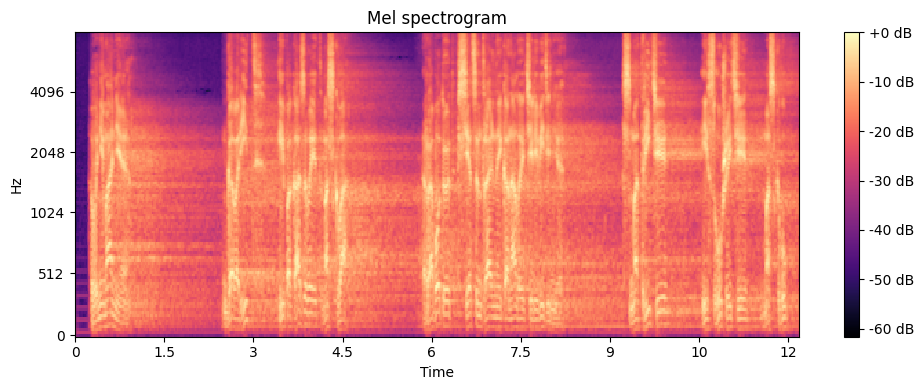

In [158]:
mel_spectrogram = wav_to_mel_spectrogram(data, sr, WINDOW_SIZE, HOP_SIZE_A)
plot_mel_spectrogram(mel_spectrogram, sr)

## Решение

In [148]:
from math import cos, pi
import scipy.fft as spft

def hanning_window(n, N):
    w = 0.5 * (1 - cos(2*pi*n / N))
    return w

def stft(x: np.ndarray, sr:int,  N: int, hop_size: int) -> np.ndarray:
    """Performs STFT by applying Hanning window
    
    ## Parameters:
    - `x: np.ndarray` - source digital signal
    - `sr: int` - sampling rate of signal
    - `frame_size: int` - size of single frame (frame_size assumed to be equal to window_size)
    - `hop_size: int` - size of hop between frames, 1/hop_size = overlap
    - `N: int` - size of Hanning window

    ## Returns:
    - `X: np.ndarray` - freq_bins/frames matrix
    - `freqs: np.ndarray` - array of frequencies per each freq_bin
    """
    freq_bins = int(N // 2 + 1) # -> (0, sr/2)Hz range
    frames = (len(x) - N) // hop_size + 1 
    X = np.zeros((freq_bins, frames), dtype='complex_')
    w = np.array([hanning_window(n, N) for n in range(N)]) # precalculated hanning window function values
    for i in range(frames):
        frame = x[i*hop_size:i*hop_size + N] * w
        X[:, i] = spft.fft(frame, N)[:freq_bins]
    return X

In [149]:
def get_stretched_params(n: int, N: int, hs: int, stretch_ratio: Union[int, float]):
    """Returns stretched audio length and sampling hop size"""
    new_n = int(n * stretch_ratio)
    new_hs = hs * (new_n - N) // (n - N)
    return new_n, new_hs


def processing(X: np.ndarray, sr: int, hs_a: int, hs_s: int) -> np.ndarray:
    """Obtaining true frequencies
    ## Parameters:
    - `X: np.ndarray` - freq_bins/frames matrix
    - `sr: int` - sampling rate of original signal
    - `hs_a: int` - hop size of original signal
    - `hs_s: int` - hop size of stretched signal

    ## Returns:
    `X_s: np.ndarray` - freq_bins/frames matrix
    """
    w_bin = (np.arange(X.shape[0]) * sr / X.shape[0]).reshape(-1, 1) # freqs per each bin
    dt_a = hs_a / sr
    dt_s = hs_s / sr
    ph = np.arctan(X.imag / X.real)
    fr_deltas = np.hstack((np.zeros((ph.shape[0], 1)), np.diff(ph, axis=1))) / dt_a - w_bin # phase deltas along all k freq_bins
    fr_deltas = np.mod(fr_deltas + pi, 2*pi) - pi # phase deltas in (-pi, pi) range
    fr_true = fr_deltas + w_bin
    ph[:, 0] = dt_s * fr_true[:, 0]
    for i in range(1, X.shape[1]):
        ph[:, i] = ph[:, i-1] + dt_s * fr_true[:, i]
    X_s = np.abs(X) * np.exp(1j * ph)       
    return X_s
    

In [150]:
def synthesis(X: np.ndarray, n: int, new_n: int, sr: int, N: int, hs_a: int, hs_s: int) -> np.ndarray:
    """Apply ifft to each frame with hanning window and add overlapping windows
    
    ## Parameters:
    - `X: np.ndarray` - freq_bins/frames matrix
    - `n: int` - number of samples in original signal
    - `sr: int` - sampling rate of original signal
    - `N: int` - size of Hanning window
    - `hs_a: int` - size of hop between frames during analysis phase
    - `r: Union[float, int]` - stretch ratio 

    ## Returns:
    `y: np.ndarray` - synthesized signal (stretched or compressed without changed pitch)
    """

    q = np.zeros((X.shape[1], new_n))
    y = np.zeros(new_n)
    w = np.array([hanning_window(n, N) for n in range(N)]) # precalculated hanning window function values
    for i in range(X.shape[1]):
        q[i, i*hs_s:i*hs_s + N] = np.real(spft.ifft(X[:, i], N)) * w
    
    # add overlapping windows
    for i in range(X.shape[1]):
        y[i*hs_s:i*hs_s + N] += q[i, i*hs_s:i*hs_s + N]
    return y


In [114]:
# generate short signal for testing
x = np.sin(2 * np.pi * 440 * np.arange(0, 1, 1/sr))
stretched_l, hs_s = get_stretched_params(len(x), WINDOW_SIZE, HOP_SIZE_A, 2.)
X = stft(x, sr, WINDOW_SIZE, HOP_SIZE_A)
y = synthesis(X, len(x), stretched_l, sr, WINDOW_SIZE, HOP_SIZE_A, hs_s)
display_sound(x, sr)
display_sound(y, sr)

In [160]:
STRETCH_RATIO = 1.
stretched_l, hs_s = get_stretched_params(len(data), WINDOW_SIZE, HOP_SIZE_A, STRETCH_RATIO)
X = stft(data, sr, WINDOW_SIZE, HOP_SIZE_A)
X_s = processing(X, sr, HOP_SIZE_A, hs_s)
y = synthesis(X_s, len(data), stretched_l, sr, WINDOW_SIZE, HOP_SIZE_A, hs_s)
display_sound(data, sr)
display_sound(y, sr)